### Set up dfs

select createdat, deletedat, requestid, tsstart, type from calendar_event
 where createdat > '2025-03-01'
and type <> 'VACATION'




In [17]:

import pandas as pd
import numpy as np

file_path = r"C:\Users\ElifYilmaz\Downloads\project 2.0.csv"

df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()


slider info select r.id as requestid, 
--l.id as leadid, 
zipregion, r.evaluationtime, r.desiredinstallationend, electricitybill, heatingbill l.mktgparamscore, a.netcontractsigned,  selfipaimportedat  -- for the two column that are present both in request and lead; request is more filled
from  request r left join lead l on l.id = r.leadid left join airtable_contracts a on a.requestid = r.id
-----NO TIME CONSTRAINT ON THIS ----- where r.createdat_date > '2025-03-01'


In [18]:


file2 = r"C:\Users\ElifYilmaz\Downloads\info client.csv"

df2 = pd.read_csv(file2)
df2.columns = df2.columns.str.lower()



### Create derived DF

In [19]:
# Create the type mapping
type_mapping = {
    'FU': 'FU',
    'FUVD': 'FU', 
    'REMINDER': 'FU',
    'VDFIELD': 'SC',
    'VD': 'SC'
}

# Create grouped_type column
df['grouped_type'] = df['type'].map(type_mapping)

In [20]:
# Create condition for net events (not cancelled and past)
df['is_net_event'] = df['deletedat'].isna() & df['is_passed']

In [22]:
# Gross counts (all events)
gross_counts = df.groupby(['requestid', 'grouped_type']).size().unstack(fill_value=0)
gross_counts.columns = [f'gross_{col}' for col in gross_counts.columns]

# Net counts (only events that actually happened)
net_counts = df[df['is_net_event']].groupby(['requestid', 'grouped_type']).size().unstack(fill_value=0)
net_counts.columns = [f'net_{col}' for col in net_counts.columns]

In [23]:
# Combine gross and net counts
counts_df = gross_counts.join(net_counts, how='outer').fillna(0)

In [24]:
df2['selfipa_done'] = df2['selfipaimportedat'].notnull().astype(int)
df2.drop('selfipaimportedat', axis=1, inplace=True) 

In [25]:
# Step 1: Convert createdat to datetime
df['createdat'] = pd.to_datetime(df['createdat'])

# Step 2: Get first gross SC and first net FU timestamps
first_gross_sc = df[df['grouped_type'] == 'SC'].groupby('requestid')['createdat'].min()
first_net_fu = df[(df['grouped_type'] == 'FU') & df['is_net_event']].groupby('requestid')['createdat'].min()

# Step 3: Calculate time difference in hours
counts_df['time_first_sc_to_first_net_fu'] = (first_net_fu - first_gross_sc).dt.total_seconds() / 3600

In [26]:
# Fix the pandas warning by using proper assignment
counts_df['time_first_sc_to_first_net_fu'] = counts_df['time_first_sc_to_first_net_fu'].fillna(-1)

# Check final dataset
print("Final dataset info:")
print(f"Shape: {counts_df.shape}")
print(f"No missing values: {counts_df.isnull().sum().sum() == 0}")

Final dataset info:
Shape: (24141, 5)
No missing values: True


In [27]:
# drop older requests that havent had a sc since march
counts_df = counts_df[counts_df['gross_SC'] != 0]
counts_df['gross_SC'].value_counts() 

gross_SC
1     15250
2      3013
3       700
4       198
5        48
6        12
7         6
10        2
23        1
8         1
Name: count, dtype: int64

In [28]:
# Separate real negative times from NaN fill values
real_negative = counts_df[
    (counts_df['time_first_sc_to_first_net_fu'] < 0) & 
    (counts_df['time_first_sc_to_first_net_fu'] != -1)
]

actual_valid_times = counts_df[counts_df['time_first_sc_to_first_net_fu'] >= 0]

print(f"Actual negative time differences (not NaN fills): {len(real_negative)}")
print(f"Positive time differences: {len(actual_valid_times)}")
print(f"NaN fills (-1): {(counts_df['time_first_sc_to_first_net_fu'] == -1).sum()}")

if len(real_negative) > 0:
    print(f"\nReal negative values range: {real_negative['time_first_sc_to_first_net_fu'].min():.2f} to {real_negative['time_first_sc_to_first_net_fu'].max():.2f} hours")

Actual negative time differences (not NaN fills): 22
Positive time differences: 7351
NaN fills (-1): 11858

Real negative values range: -4146.53 to -22.24 hours


In [29]:
#handle negative time difference
# Option 1: Remove outliers entirely (set to NaN, then fill with -1)
counts_df.loc[counts_df['time_first_sc_to_first_net_fu'] < -1, 'time_first_sc_to_first_net_fu'] = -1


In [30]:
# Verify the cleanup
print("After removing outliers:")
print(f"Negative values (excluding -1 fills): {((counts_df['time_first_sc_to_first_net_fu'] < 0) & (counts_df['time_first_sc_to_first_net_fu'] != -1)).sum()}")
print(f"Valid positive time differences: {(counts_df['time_first_sc_to_first_net_fu'] > 0).sum()}")
print(f"NaN fills (-1): {(counts_df['time_first_sc_to_first_net_fu'] == -1).sum()}")

# Final dataset summary
print(f"\nFinal dataset shape: {counts_df.shape}")
print("Ready to join with target variable!")

After removing outliers:
Negative values (excluding -1 fills): 0
Valid positive time differences: 7351
NaN fills (-1): 11880

Final dataset shape: (19231, 5)
Ready to join with target variable!


In [31]:
counts_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19231 entries, 2039 to 128394
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gross_FU                       19231 non-null  int64  
 1   gross_SC                       19231 non-null  int64  
 2   net_FU                         19231 non-null  float64
 3   net_SC                         19231 non-null  float64
 4   time_first_sc_to_first_net_fu  19231 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 901.5 KB


In [32]:

counts_df = counts_df.reset_index()
counts_df.head()
# Now requestid is a regular column you can keep or reference

,requestid,gross_FU,gross_SC,net_FU,net_SC,time_first_sc_to_first_net_fu
0,2039,0,2,0.0,0.0,-1.000000
1,3279,0,1,0.0,1.0,-1.000000
2,3583,1,1,1.0,1.0,120.043056
3,3729,8,1,8.0,1.0,73.835556
4,3852,2,1,2.0,1.0,42.193889


merge comes later because i gad to create a df of the request first.

In [33]:
# Left join to add target variable
#final_df1 = counts_df.merge(contract, on='requestid', how='left')
# unnecessairy join because df2 has netcontractsigned info 

final_df = counts_df.merge(df2, on='requestid', how='left')


# Fill non-matching requestids with 0 for the target
final_df['netcontractsigned'] = final_df['netcontractsigned'].fillna(0)

# Check the result
print(f"Final dataset shape: {final_df.shape}")
print(f"Target variable distribution:")
print(final_df['netcontractsigned'].value_counts())
print(f"\nColumns: {list(final_df.columns)}")

Final dataset shape: (19245, 14)
Target variable distribution:
netcontractsigned
0.0    18809
1.0      436
Name: count, dtype: int64

Columns: ['requestid', 'gross_FU', 'gross_SC', 'net_FU', 'net_SC', 'time_first_sc_to_first_net_fu', 'zipregion', 'evaluationtime', 'desiredinstallationend', 'electricitybill', 'heatingbill', 'mktgparamscore', 'netcontractsigned', 'selfipa_done']


### Move forward with final df

In [ ]:
#Checkpoint:
df_backup = final_df.copy()


In [ ]:
#df_final = df_backup.copy()

#### Exploratory checks

In [61]:
# basic check

# Check final data types and any remaining issues
print("Data types:")
print(final_df.dtypes)
print(f"\nAny missing values: {final_df.isnull().sum().sum()}")

# Separate features from target for ML
X = final_df.drop(['requestid', 'netcontractsigned'], axis=1)
y = final_df['netcontractsigned']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Basic feature statistics
print("Feature distributions:")
print(X.describe())

# Check feature correlations with target
print(f"\nFeature correlations with target:")
correlations = final_df[['gross_FU', 'gross_SC', 'net_FU', 'net_SC', 'time_first_sc_to_first_net_fu', 'netcontractsigned']].corr()['netcontractsigned'].drop('netcontractsigned')
print(correlations.sort_values(ascending=False))

# Look at feature distributions by target class
print(f"\nMean feature values by target class:")
print(final_df.groupby('netcontractsigned')[['gross_FU', 'gross_SC', 'net_FU', 'net_SC', 'time_first_sc_to_first_net_fu']].mean())

Data types:
requestid                           int64
gross_FU                            int64
gross_SC                            int64
net_FU                            float64
net_SC                            float64
time_first_sc_to_first_net_fu     float64
zipregion                          object
evaluationtime                     object
desiredinstallationend             object
electricitybill                   float64
heatingbill                       float64
mktgparamscore                     object
netcontractsigned                 float64
selfipa_done                        int64
desiredinstallationend_encoded      int64
mktg_Affiliation                     bool
mktg_Google                          bool
mktg_Mediago                         bool
mktg_Meta                            bool
mktg_Organic                         bool
mktg_Other                           bool
mktg_Outbrain                        bool
mktg_Referral                        bool
mktg_Taboola          

In [23]:
# Check missing values by column
print("Missing values per column:")
missing_counts = final_df.isnull().sum()
print(missing_counts[missing_counts > 0])

# Check the object columns that need encoding
object_cols = final_df.select_dtypes(include=['object']).columns
print(f"\nObject columns needing encoding: {list(object_cols)}")

Missing values per column:
zipregion                  608
evaluationtime             241
desiredinstallationend     242
electricitybill           6349
mktgparamscore             926
dtype: int64

Object columns needing encoding: ['zipregion', 'evaluationtime', 'desiredinstallationend', 'mktgparamscore']


In [48]:
# categorical values
# Check unique values in categorical columns
for col in ['zipregion', 'evaluationtime', 'desiredinstallationend', 'mktgparamscore']:
    unique_count = final_df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count < 20:  # Show values if not too many
        print(f"  Values: {sorted(final_df[col].dropna().unique())}")
    print()

zipregion: 20 unique values

evaluationtime: 9 unique values
  Values: ['3-6 mesi', '<3 mesi', '>6 mesi', 'curious', 'evaluation', 'less_than_three_months', 'more_than_six_months', 'understand_need', 'understand_purchase']

desiredinstallationend: 9 unique values
  Values: ['1-2mesi', '3-4mesi', '5+mesi', 'Non lo so', 'dont_know', 'more_than_5_months', 'one_to_two_months', 'short', 'three_to_four_months']

mktgparamscore: 13 unique values
  Values: ['Affiliation', 'Google', 'Mediago', 'Meta', 'Organic', 'Other', 'Outbrain', 'Referral', 'Taboola', 'TikTok', 'Youtube', 'd2d', 'form_classico']



In [25]:
# Check if zeros in electricitybill are meaningful
print("Electricitybill value counts (first 10):")
print(final_df['electricitybill'].value_counts().head(10))

# Check zipregion unique values since we couldn't see them
print(f"\nZipregion unique values:")
print(f"Count: {final_df['zipregion'].nunique()}")
print("Sample values:", final_df['zipregion'].dropna().unique()[:10])

# For encoding strategy:
# evaluationtime (8 values) - ordinal or one-hot
# desiredinstallationend (5 values) - ordinal (time-based)  
# mktgparamscore (13 values) - one-hot (marketing channels)
# zipregion (20 values) - might need grouping or target encoding

Electricitybill value counts (first 10):
electricitybill
90.0     3157
100.0    1656
150.0    1013
120.0     614
200.0     601
80.0      587
70.0      431
0.0       336
60.0      315
130.0     301
Name: count, dtype: int64

Zipregion unique values:
Count: 20
Sample values: ['Lombardia' 'Veneto' 'Emilia-Romagna' 'Toscana' 'Friuli-Venezia Giulia'
 'Puglia' 'Piemonte' 'Liguria' 'Calabria' 'Lazio']


In [26]:
# Check if missingness patterns relate to conversion
print("Conversion rates by missingness:")
for col in ['zipregion', 'evaluationtime', 'desiredinstallationend', 'electricitybill', 'mktgparamscore']:
    missing_conversion = final_df[final_df[col].isnull()]['netcontractsigned'].mean()
    present_conversion = final_df[final_df[col].notnull()]['netcontractsigned'].mean()
    
    print(f"{col}:")
    print(f"  Missing: {missing_conversion:.3f} ({final_df[col].isnull().sum()} cases)")
    print(f"  Present: {present_conversion:.3f} ({final_df[col].notnull().sum()} cases)")
    print()

Conversion rates by missingness:
zipregion:
  Missing: 0.031 (608 cases)
  Present: 0.022 (18637 cases)

evaluationtime:
  Missing: 0.008 (241 cases)
  Present: 0.023 (19004 cases)

desiredinstallationend:
  Missing: 0.008 (242 cases)
  Present: 0.023 (19003 cases)

electricitybill:
  Missing: 0.012 (6349 cases)
  Present: 0.028 (12896 cases)

mktgparamscore:
  Missing: 0.021 (926 cases)
  Present: 0.023 (18319 cases)



In [45]:
# set wrong bill values to nan
# Replace specific values with NaN
final_df['electricitybill'] = final_df['electricitybill'].replace([0, 1, -1], pd.NA)
final_df['heatingbill'] = final_df['heatingbill'].replace([0, 1, -1], pd.NA)

In [62]:
# Create missing value indicators (these will be strong features!)
missing_cols = ['zipregion', 'evaluationtime', 'desiredinstallationend', 'electricitybill', 'heatingbill', 'mktgparamscore']

for col in missing_cols:
    final_df[f'{col}_missing'] = final_df[col].isnull().astype(int)

# Check the predictive power of missing indicators
print("Missing indicator correlations with target:")
missing_indicators = [f'{col}_missing' for col in missing_cols]
missing_corrs = final_df[missing_indicators + ['netcontractsigned']].corr()['netcontractsigned'].drop('netcontractsigned')
print(missing_corrs.sort_values())

Missing indicator correlations with target:
electricitybill_missing          -0.051951
mktgparamscore_missing           -0.003229
zipregion_missing                 0.010433
heatingbill_missing               0.028544
evaluationtime_missing                 NaN
desiredinstallationend_missing         NaN
Name: netcontractsigned, dtype: float64


In [63]:
# Better metrics for imbalanced data
from sklearn.metrics import mutual_info_score

# Calculate mutual information (better for imbalanced targets)
print("Mutual Information scores (higher = more predictive):")
feature_cols = ['net_SC', 'net_FU', 'gross_SC', 'gross_FU', 'time_first_sc_to_first_net_fu',
               'electricitybill_missing', 'mktgparamscore_missing', 'zipregion_missing']

for col in feature_cols:
    if col in final_df.columns:
        mi_score = mutual_info_score(final_df[col], final_df['netcontractsigned'])
        print(f"{col}: {mi_score:.4f}")

# Also check mean differences between classes (more intuitive)
print(f"\nMean feature values by class (showing actual business impact):")
class_means = final_df.groupby('netcontractsigned')[feature_cols].mean()
print(class_means)

Mutual Information scores (higher = more predictive):
net_SC: 0.0114
net_FU: 0.0049
gross_SC: 0.0003
gross_FU: 0.0044
time_first_sc_to_first_net_fu: 0.0650
electricitybill_missing: 0.0015
mktgparamscore_missing: 0.0000
zipregion_missing: 0.0000

Mean feature values by class (showing actual business impact):
                     net_SC    net_FU  gross_SC  gross_FU  \
netcontractsigned                                           
0.0                0.580679  0.926312  1.279334  1.733000   
1.0                0.993119  1.665138  1.211009  2.256881   

                   time_first_sc_to_first_net_fu  electricitybill_missing  \
netcontractsigned                                                           
0.0                                   105.364562                 0.339146   
1.0                                   105.073203                 0.174312   

                   mktgparamscore_missing  zipregion_missing  
netcontractsigned                                             
0.0        

c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


#### Handle wrong bills
will set wrong values to nan because adasyn handle it better; also nn can handle

In [65]:
# Function to clean and validate billing columns
def clean_billing_column(series, column_name):
    """Clean billing column: set negative values and extreme outliers to replacement value"""
    
    # Convert to numeric, coerce errors to NaN
    series_clean = pd.to_numeric(series, errors='coerce')
    
    # Define reasonable bounds (adjust these based on your domain knowledge)
    min_reasonable = 0  # Bills shouldn't be negative
    max_reasonable = 2000  # Adjust based on your market (e.g., €1000/month seems high)
    
    # Count issues for reporting
    negative_count = (series_clean < min_reasonable).sum()
    outlier_count = (series_clean > max_reasonable).sum()
    
    print(f"{column_name}:")
    print(f"  - Negative values: {negative_count}")
    print(f"  - Values > {max_reasonable}: {outlier_count}")
    print(f"  - Original NaN: {series.isna().sum()}")
    
    # Replace problematic values
    series_clean.loc[series_clean < min_reasonable] = np.nan  # or -1
    series_clean.loc[series_clean > max_reasonable] = np.nan  # or -1
    
    return series_clean

# Apply cleaning
final_df['heatingbill'] = clean_billing_column(final_df['heatingbill'], 'heatingbill')
final_df['electricitybill'] = clean_billing_column(final_df['electricitybill'], 'electricitybill')

heatingbill:
  - Negative values: 0
  - Values > 2000: 0
  - Original NaN: 14217
electricitybill:
  - Negative values: 0
  - Values > 2000: 0
  - Original NaN: 6455


Encoding categorical

In [66]:
# desiredinstallationend
type_mapping = {
    # Original Italian values
    '3-4mesi': 'three_to_four_months', 
    '5+mesi': 'more_than_5_months',
    '1-2mesi': 'one_to_two_months',
    'Non lo so': 'dont_know',
    'short': np.nan,
    # Already mapped values (keep as-is)
    'dont_know': 'dont_know',
    'three_to_four_months': 'three_to_four_months',
    'one_to_two_months': 'one_to_two_months', 
    'more_than_5_months': 'more_than_5_months',
    # Handle string 'nan'
    'nan': np.nan
}

final_df['desiredinstallationend1'] = final_df['desiredinstallationend'].map(type_mapping)

In [71]:
final_df['evaluationtime1'].value_counts()

evaluationtime1
understand_purchase    7370
understand_need        7363
evaluation             3305
curious                 938
Name: count, dtype: int64

In [70]:

# evaluationtime
type_mapping = {
    # Original Italian values
    '3-6 mesi': np.nan,
    '<3 mesi': np.nan,
    '>6 mesi': np.nan,
    # Already mapped English values
    'less_than_three_months': np.nan,
    'more_than_six_months': np.nan,
    # Other values that appear in your data
    'understand_need': 'understand_need',  # or map to np.nan if you don't want these
    'understand_purchase': 'understand_purchase',  # or map to np.nan if you don't want these
    'evaluation': 'evaluation',  # or map to np.nan if you don't want these
    'curious': 'curious',  # or map to np.nan if you don't want these
    # Handle string 'nan'
    'nan': np.nan
}

# Create grouped_type column
final_df['evaluationtime1'] = final_df['evaluationtime'].map(type_mapping)




In [72]:
# Replace the old columns directly
final_df['desiredinstallationend'] = final_df['desiredinstallationend1']
final_df['evaluationtime'] = final_df['evaluationtime1']

# Drop the temporary columns
final_df = final_df.drop(['desiredinstallationend1', 'evaluationtime1'], axis=1)

In [73]:
# handle nan before encoding
final_df['desiredinstallationend'] = final_df['desiredinstallationend'].fillna('missing')
final_df['evaluationtime'] = final_df['evaluationtime'].fillna('missing')


In [74]:
# Start with ordinal encoding for time-based features
from sklearn.preprocessing import LabelEncoder

# Ordinal encoding for desiredinstallationend (time-based order)
time_order = [ 'one_to_two_months', 'three_to_four_months', 'more_than_5_months', 'dont_know', 'missing']
final_df['desiredinstallationend_encoded'] = final_df['desiredinstallationend'].map({val: i for i, val in enumerate(time_order)})

In [75]:
# One-hot encoding for marketing channels (mktgparamscore)
marketing_dummies = pd.get_dummies(final_df['mktgparamscore'], prefix='mktg')
final_df = pd.concat([final_df, marketing_dummies], axis=1)

# One-hot encoding for regions (zipregion) 
region_dummies = pd.get_dummies(final_df['zipregion'], prefix='region')
final_df = pd.concat([final_df, region_dummies], axis=1)

# Label encoding for evaluationtime (mixed ordinal/categorical)
le = LabelEncoder()
final_df['evaluationtime_encoded'] = le.fit_transform(final_df['evaluationtime'])

print(f"Dataset shape after encoding: {final_df.shape}")
print(f"New dummy columns created: {len(marketing_dummies.columns) + len(region_dummies.columns)}")

Dataset shape after encoding: (19245, 88)
New dummy columns created: 33


In [76]:
# Drop original categorical columns and create final feature matrix
columns_to_drop = ['requestid', 'zipregion', 'evaluationtime', 'desiredinstallationend', 'mktgparamscore', 'netcontractsigned']
X_final = final_df.drop(columns=columns_to_drop)
y_final = final_df['netcontractsigned']

print(f"Final feature matrix: {X_final.shape}")
print(f"Final target vector: {y_final.shape}")
print(f"Feature columns: {len(X_final.columns)} features")

# Quick check of final dataset
print(f"\nTarget distribution:")
print(y_final.value_counts(normalize=True))
print(f"\nNo missing values: {X_final.isnull().sum().sum() == 0}")

Final feature matrix: (19245, 82)
Final target vector: (19245,)
Feature columns: 82 features

Target distribution:
netcontractsigned
0.0    0.977345
1.0    0.022655
Name: proportion, dtype: float64

No missing values: False


At this point we have our dataset encoded, mostly one hot encoding which made the dset muhc bigger, was it necessary idk but x_final and y_final are the final ones

In [81]:
# Fix electricitybill missing values
X_final['electricitybill'] = X_final['electricitybill'].fillna(X_final['electricitybill'].median())
X_final['heatingbill'] = X_final['heatingbill'].fillna(X_final['heatingbill'].median())

# Fix desiredinstallationend_encoded - NaN means 'Unknown' which should be 0
X_final['desiredinstallationend_encoded'] = X_final['desiredinstallationend_encoded'].fillna(0)

# Verify all missing values are gone
print(f"Remaining missing values: {X_final.isnull().sum().sum()}")
print(f"Dataset ready: {X_final.isnull().sum().sum() == 0}")

# Final check
print(f"\nFinal dataset shape: {X_final.shape}")
print(f"Target balance: {y_final.mean():.1%} positive class")

Remaining missing values: 0
Dataset ready: True

Final dataset shape: (19245, 82)
Target balance: 2.3% positive class


In [ ]:
# scaling when needed
continuous_cols= [
    'time_first_sc_to_first_net_fu',
    'electricitybill', 
    'heatingbill'
]
from sklearn.preprocessing import StandardScaler

# Scale only the continuous features
scaler = StandardScaler()
X_final[continuous_cols] = scaler.fit_transform(X_final[continuous_cols])

In [91]:
# Check your actual dataset for duplicates
duplicate_cols = []
cols = X_final.columns.tolist()

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if X_final[cols[i]].equals(X_final[cols[j]]):
            duplicate_cols.append((cols[i], cols[j]))

print("Duplicate column pairs:", duplicate_cols)
print(f"Original shape: {X_final.shape}")

# Remove duplicates if any found
X_final_clean = X_final.loc[:, ~X_final.columns.duplicated()]
print(f"After removing duplicates: {X_final_clean.shape}")

Duplicate column pairs: [('mktg_Affiliation', 'mktg_Affiliation'), ('mktg_Google', 'mktg_Google'), ('mktg_Mediago', 'mktg_Mediago'), ('mktg_Meta', 'mktg_Meta'), ('mktg_Organic', 'mktg_Organic'), ('mktg_Other', 'mktg_Other'), ('mktg_Outbrain', 'mktg_Outbrain'), ('mktg_Referral', 'mktg_Referral'), ('mktg_Taboola', 'mktg_Taboola'), ('mktg_TikTok', 'mktg_TikTok'), ('mktg_Youtube', 'mktg_Youtube'), ('mktg_d2d', 'mktg_d2d'), ('mktg_form_classico', 'mktg_form_classico'), ('region_Abruzzo', 'region_Abruzzo'), ('region_Basilicata', 'region_Basilicata'), ('region_Calabria', 'region_Calabria'), ('region_Campania', 'region_Campania'), ('region_Emilia-Romagna', 'region_Emilia-Romagna'), ('region_Friuli-Venezia Giulia', 'region_Friuli-Venezia Giulia'), ('region_Lazio', 'region_Lazio'), ('region_Liguria', 'region_Liguria'), ('region_Lombardia', 'region_Lombardia'), ('region_Marche', 'region_Marche'), ('region_Molise', 'region_Molise'), ('region_Piemonte', 'region_Piemonte'), ('region_Puglia', 'region

Class imbalance


In [85]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19245 entries, 0 to 19244
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_FU                        19245 non-null  int64  
 1   gross_SC                        19245 non-null  int64  
 2   net_FU                          19245 non-null  float64
 3   net_SC                          19245 non-null  float64
 4   time_first_sc_to_first_net_fu   19245 non-null  float64
 5   electricitybill                 19245 non-null  float64
 6   heatingbill                     19245 non-null  float64
 7   selfipa_done                    19245 non-null  int64  
 8   desiredinstallationend_encoded  19245 non-null  int64  
 9   mktg_Affiliation                19245 non-null  bool   
 10  mktg_Google                     19245 non-null  bool   
 11  mktg_Mediago                    19245 non-null  bool   
 12  mktg_Meta                       

In [92]:
import numpy as np
# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_final), y=y_final)
class_weight_dict = dict(zip(np.unique(y_final), class_weights))

print(f"Recommended class weights: {class_weight_dict}")
print(f"Weight ratio: {class_weight_dict[1.0]/class_weight_dict[0.0]:.1f}:1 for positive class")

Recommended class weights: {np.float64(0.0): np.float64(0.5115901961826785), np.float64(1.0): np.float64(22.06995412844037)}
Weight ratio: 43.1:1 for positive class


In [96]:
# SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# First, split your data (important to do this BEFORE SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}")
print(f"After SMOTE: {X_train_smote.shape}")
print(f"Original class distribution: {y_train.value_counts()}")
print(f"After SMOTE class distribution: {y_train_smote.value_counts()}")

Original training set: (15396, 82)
After SMOTE: (30094, 82)
Original class distribution: netcontractsigned
0.0    15047
1.0      349
Name: count, dtype: int64
After SMOTE class distribution: netcontractsigned
0.0    15047
1.0    15047
Name: count, dtype: int64


model

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np

# Build the neural network
def create_model(input_dim):
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        # Output layer (sigmoid for binary classification)
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Create the model
model = create_model(X_train_smote.shape[1])

# Print model summary
print("Model Architecture:")
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Make predictions on test set
print("\nMaking predictions...")
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Evaluate the model
print("\n=== MODEL EVALUATION ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (Recall): {tp / (tp + fn):.4f}")

# Plot training history (optional)
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Loss
    axes[0,0].plot(history.history['loss'], label='Training Loss')
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,0].set_title('Model Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    
    # Accuracy
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,1].set_title('Model Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    
    # Precision
    axes[1,0].plot(history.history['precision'], label='Training Precision')
    axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1,0].set_title('Model Precision')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()
    
    # Recall
    axes[1,1].plot(history.history['recall'], label='Training Recall')
    axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1,1].set_title('Model Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Uncomment to plot training history
# plot_training_history(history)

print("\n=== TRAINING COMPLETE ===")
print("Use y_pred_proba for probability predictions")
print("Use y_pred for binary predictions")

Model Architecture:


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,761 (85.00 KB)

 Trainable params: 21,377 (83.50 KB)

 Non-trainable params: 384 (1.50 KB)


Training the model...
Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8407 - loss: 0.3473 - precision: 0.7872 - recall: 0.7882 - val_accuracy: 0.9520 - val_loss: 0.1701 - val_precision: 1.0000 - val_recall: 0.9520 - learning_rate: 0.0010
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9137 - loss: 0.2094 - precision: 0.8885 - recall: 0.8804 - val_accuracy: 0.9620 - val_loss: 0.1249 - val_precision: 1.0000 - val_recall: 0.9620 - learning_rate: 0.0010
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9269 - loss: 0.1806 - precision: 0.9049 - recall: 0.8998 - val_accuracy: 0.9154 - val_loss: 0.1874 - val_precision: 1.0000 - val_recall: 0.9154 - learning_rate: 0.0010
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9334 - loss: 0.1657 - precision: 0.9159 - recall: 0.9055 - val_accuracy: 0.9801 - val_loss: 0.0752 - val_precision: 1.0000 - val_recall: 0.9801 - learning_rate: 0.0010
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━

In [99]:
# Check if model is overfitting
print("Final epoch results:")
print(f"Training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Training loss: {history.history['loss'][-1]:.4f}")
print(f"Validation loss: {history.history['val_loss'][-1]:.4f}")

Final epoch results:
Training accuracy: 0.9757
Validation accuracy: 0.9934
Training loss: 0.0687
Validation loss: 0.0301


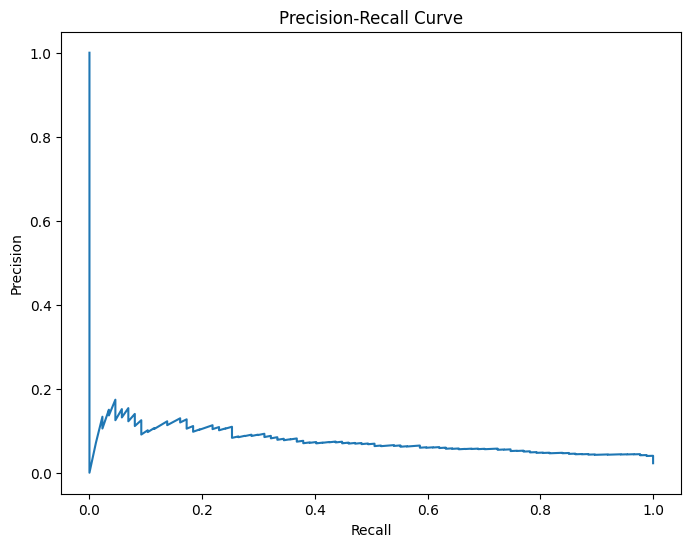


With threshold 0.3:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      3762
         1.0       0.11      0.18      0.13        87

    accuracy                           0.95      3849
   macro avg       0.54      0.57      0.55      3849
weighted avg       0.96      0.95      0.95      3849



In [101]:
# Find optimal threshold for your business case
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Try different threshold (default is 0.5)
threshold = 0.3  # Lower threshold = catch more positive cases
y_pred_new = (y_pred_proba > threshold).astype(int).flatten()
print(f"\nWith threshold {threshold}:")
print(classification_report(y_test, y_pred_new))

In [102]:
# Look at the confusion matrix breakdown
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp} (predicted purchase, didn't buy)")
print(f"False Negatives: {fn} (missed customers who would buy)")
print(f"True Positives: {tp} (correctly identified buyers)")

# Business cost analysis
cost_per_fp = 50  # Cost of targeting someone who won't buy
revenue_per_tp = 1000  # Revenue from correctly identified buyer
cost_per_fn = 1000  # Lost revenue from missed buyer

total_profit = (tp * revenue_per_tp) - (fp * cost_per_fp) - (fn * cost_per_fn)
print(f"Estimated profit impact: ${total_profit}")

True Negatives: 3668
False Positives: 94 (predicted purchase, didn't buy)
False Negatives: 74 (missed customers who would buy)
True Positives: 13 (correctly identified buyers)
Estimated profit impact: $-65700


#### end of first attempt

In [104]:
# Try class weights instead of SMOTE
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train), 
                                   y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")

# Retrain original model with class weights (no SMOTE)
model_weighted = create_model(X_train.shape[1])
history_weighted = model_weighted.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,  # Add this
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Class weights: {0: np.float64(0.5115969960789526), 1: np.float64(22.05730659025788)}
Epoch 1/100


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5744 - loss: 0.6972 - precision: 0.0370 - recall: 0.6923 - val_accuracy: 0.5692 - val_loss: 0.6738 - val_precision: 0.0447 - val_recall: 0.9841 - learning_rate: 0.0010
Epoch 2/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6513 - loss: 0.5555 - precision: 0.0519 - recall: 0.8112 - val_accuracy: 0.6692 - val_loss: 0.5280 - val_precision: 0.0524 - val_recall: 0.8889 - learning_rate: 0.0010
Epoch 3/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6902 - loss: 0.4863 - precision: 0.0590 - recall: 0.8252 - val_accuracy: 0.6614 - val_loss: 0.5033 - val_precision: 0.0537 - val_recall: 0.9365 - learning_rate: 0.0010
Epoch 4/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6869 - loss: 0.4589 - precision: 0.0599 - recall: 0.8497 - val_accuracy: 0.7386 - val_loss: 0.4084 - val_precision: 0.0666 - val_recall: 0.9048 - learning_rate: 0.0010
Epoch 5/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7265 

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.57      0.72      3762
         1.0       0.04      0.84      0.08        87

    accuracy                           0.57      3849
   macro avg       0.52      0.70      0.40      3849
weighted avg       0.97      0.57      0.71      3849



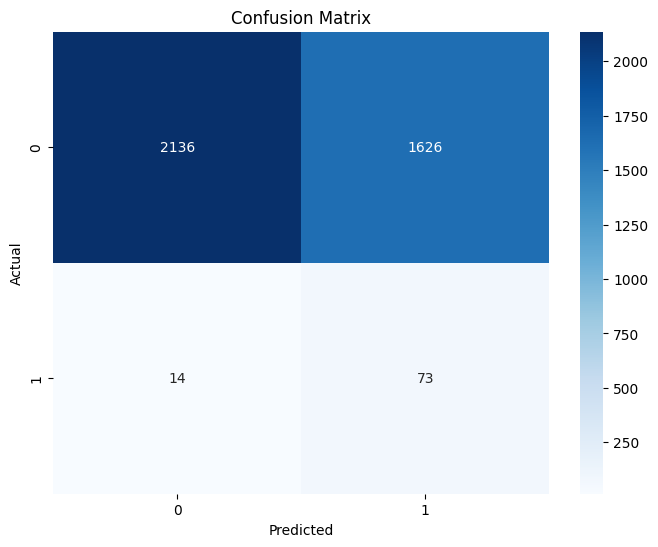

ValueError: too many values to unpack (expected 2)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions
y_pred = model_weighted.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



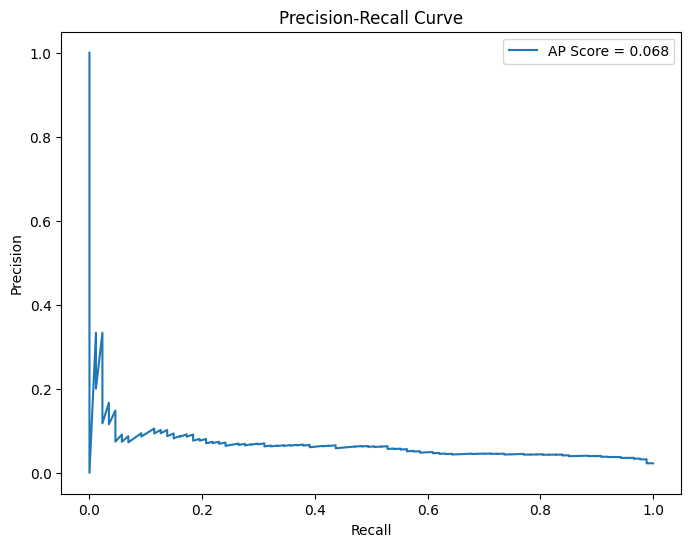

Average Precision Score: 0.0677


In [107]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall curve is much better for imbalanced data
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
ap_score = average_precision_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP Score = {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print(f"Average Precision Score: {ap_score:.4f}")

Better recall is more important than accuracy
No smote method seems to have better recall for 1??